<a href="https://colab.research.google.com/github/MohsenJadidi/Automatic-Modulation-Classification-AMC/blob/master/CLDNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Importing the dataset (Copy from CNN.ipynb and merge cells)

In [2]:
import pickle
import numpy as np
fileName = 'RML2016.10a_dict.pkl'
with open("/content/drive/My Drive/Colab Notebooks/"+fileName,'rb') as f:
  data = pickle.load(f,encoding='bytes')
 
X = []
labels = [] # label each example by a pair (modulation type, snr)
total_examples = 0
analog = [b'AM-DSB', b'AM-SSB', b'WBFM']

for mod_type, snr in data.keys():
    if (mod_type not in analog):      
        current_matrix = data[(mod_type, snr)]        
        total_examples += current_matrix.shape[0]
        for i in range(current_matrix.shape[0]):
            X.append(current_matrix[i])
            labels.append((str(mod_type, 'ascii'), snr)) # mod_type is of type bytes
    
X = np.array(X)         # First row is QPSK snr=2, seconde is PAM4 snr=8 , ...
labels = np.array(labels)

y = labels[:,0]

print(f'loaded {total_examples} signal vectors into X{X.shape} and their corresponding'
      f' labels into labels{labels.shape}')  
# print(np.unique(labels[:,0]))

# Encoding categorical data
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
labelencoder_y = LabelEncoder()
y = labelencoder_y.fit_transform(y)
onehotencoder = OneHotEncoder()
y = onehotencoder.fit_transform(y.reshape(-1,1)).toarray()

snrList = [str(2*i-20) for i in range(20)]  # snrList = -20, -18, -16 , ... ,0, ... ,18
snr = snrList[19]
numberOfEachExamples = 1000
print("SNR :", snr)

output = [[labels[i*numberOfEachExamples, 0],y[i*numberOfEachExamples]] for i in range(int(X.shape[0]/numberOfEachExamples))]
output = dict(output)

X_snr = []
y_snr = []

for i in range(X.shape[0]):
    if labels[i,1] == snr:
        X_snr.append(X[i])
        y_snr.append(y[i])

X_snr = np.array(X_snr)
y_snr = np.array(y_snr)  

###### Splitting the dataset into the Training set and Test set ######
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_snr, y_snr, test_size = 0.2, random_state = 0)
# The below line better for Cross_val part
#X_train, X_test, y_train, y_test = train_test_split(X_snr, y_snr, test_size = 1, random_state = 0)

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
# StandardScaler expected <= 2.
#X_train = X_train.reshape([6400,256])
X_train = X_train.reshape([X_train.shape[0],256])
X_train = sc.fit_transform(X_train)
X_train = X_train.reshape([X_train.shape[0],2,128])
#X_test = X_test.reshape([1600,256])
X_test = X_test.reshape([X_test.shape[0],256])
X_test = sc.transform(X_test)
X_test = X_test.reshape([X_test.shape[0],2,128])

# Reshape
X_train = X_train.reshape(-1,2, 128, 1)   #Reshape for CNN -  (6400,2,128)->(6400,2,128,1)!!
X_test = X_test.reshape(-1,2, 128, 1)

loaded 160000 signal vectors into X(160000, 2, 128) and their corresponding labels into labels(160000, 2)
SNR : 18


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


## Import Module

In [0]:
import keras
from keras.models import Model, Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Reshape

#Making CLDNN0 model

In [4]:
classifier = Sequential()

dout = 0.4
classifier.add(Conv2D(256,(1,3), input_shape =  (2,128,1), activation = 'relu', padding='same')) # 256=number of filter
classifier.add(Dropout(rate = dout))
classifier.add(Conv2D(256,2,3, activation = 'relu'))
classifier.add(Dropout(rate = dout))
classifier.add(Conv2D(80,(1,3), activation = 'relu', padding='same'))
classifier.add(Dropout(rate = dout))
classifier.add(Conv2D(80,(1,3), activation = 'relu', padding='same'))
classifier.add(Dropout(rate = dout))
classifier.add(Reshape(target_shape=(126,80)))

classifier.add(LSTM(50))

classifier.add(Dense(output_dim = 128 , activation = 'relu')) # hidden layer
classifier.add(Dense(output_dim = 8 , activation = 'softmax'))

#from keras import optimizers
#adamOpt = optimizers.adam(lr = 0.01)

classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

#logger = keras.callbacks.TensorBoard(log_dir="logs", write_graph=True, histogram_freq=5)

classifier.summary()
print("Model Created!")

W0807 07:39:44.575204 139885751699328 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0807 07:39:44.610814 139885751699328 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0807 07:39:44.616693 139885751699328 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0807 07:39:44.643281 139885751699328 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0807 07:39:44.652224 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 2, 128, 256)       1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 128, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 126, 256)       393472    
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 126, 256)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 126, 80)        61520     
_________________________________________________________________
dropout_3 (Dropout)          (None, 1, 126, 80)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 126, 80)        19280     
__________

# Fitting model

In [6]:
batch = 32
epoch = 25
history = classifier.fit(X_train, y_train, batch_size = batch, epochs = epoch, validation_data=(X_test, y_test))
#history = classifier.fit(X_train, y_train, batch_size = batch, epochs = epoch)

Train on 6400 samples, validate on 1600 samples
Epoch 1/25
6400/6400 [==============================] - 41s 6ms/step - loss: 1.7757 - acc: 0.2589 - val_loss: 1.6024 - val_acc: 0.3081
Epoch 2/25
6400/6400 [==============================] - 53s 8ms/step - loss: 1.4902 - acc: 0.3802 - val_loss: 1.3030 - val_acc: 0.4400
Epoch 3/25
6400/6400 [==============================] - 105s 16ms/step - loss: 1.2788 - acc: 0.4600 - val_loss: 1.0621 - val_acc: 0.5144
Epoch 4/25
6400/6400 [==============================] - 46s 7ms/step - loss: 1.0100 - acc: 0.5583 - val_loss: 0.8877 - val_acc: 0.5787
Epoch 5/25
6400/6400 [==============================] - 39s 6ms/step - loss: 0.8596 - acc: 0.6370 - val_loss: 1.4222 - val_acc: 0.4288
Epoch 6/25
6400/6400 [==============================] - 40s 6ms/step - loss: 0.7082 - acc: 0.6739 - val_loss: 0.5622 - val_acc: 0.7244
Epoch 7/25
6400/6400 [==============================] - 50s 8ms/step - loss: 0.5186 - acc: 0.7464 - val_loss: 0.5155 - val_acc: 0.7381
Epoch

# Prediction 

In [7]:
y_pred = classifier.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

y_real = np.argmax(y_test, axis=1)
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_real, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

acc_test = classifier.evaluate(X_test, y_test)[1]
acc_train = classifier.evaluate(X_train, y_train)[1]

print("Acc Test : ", acc_test)
print("Acc Train : ", acc_train)


6400/6400 [==============================] - 13s 2ms/step
Acc Test :  0.89125
Acc Train :  0.9009375


# Plot Confusion Matrix

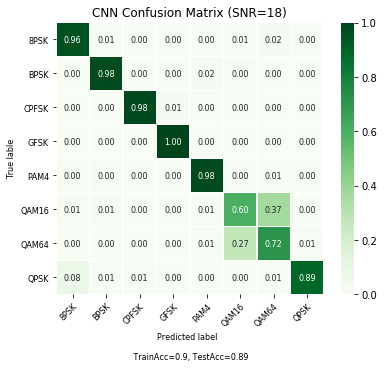

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

modulation_order = []
modulation_order_dict = dict()

for key,value in output.items():
    modulation_order_dict[np.argmax(value)] = str(key)
    
for i in range(8):
    modulation_order.append(modulation_order_dict[i])
    
    
    
cmDataFrame = pd.DataFrame(cm_norm, index=modulation_order, columns = modulation_order)
plt.figure(figsize=(6, 5))
ax = sns.heatmap(cmDataFrame, annot=True, annot_kws={"size": 8}, fmt='.2f', linewidths=.5, cmap="Greens")

plt.title(f"CNN Confusion Matrix (SNR={snr})")
plt.xlabel("Predicted label  \n\n TrainAcc={:.2}, TestAcc={:.2}".format(acc_train,acc_test), fontsize=8)
plt.ylabel("True lable", fontsize=8)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor", fontsize=8)
plt.setp(ax.get_yticklabels(), fontsize=8)
fig = ax.get_figure()